<a href="https://colab.research.google.com/github/hwangsae91/project_so/blob/master/exploration/221007/%5BExp_07%5D20221007.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# google colab전용
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# exploration 7번째 과제</br>
@ 황한용(3기/쏘카)

## 라이브러리 선언

In [2]:
import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
import glob # 폴더 안의 파일전체 리스트를 불러오는 모듈
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리 

## 상수선언

In [3]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/data/self" # 데이터 기본경로
SELF_PATH = DATA_PATH + "/face/*" # 셀카경로
MODEL_PATH = DATA_PATH + "/model/shape_predictor_68_face_landmarks.dat"
MODEL_GTX_PATH = DATA_PATH + "/model/shape_predictor_68_face_landmarks_GTX.dat"
FILTER_PATH = DATA_PATH + "/filter/cat-whiskers.png" # 필터경로
PYRAMID_NUM = 4 # 얼굴인식을 위한 image piramid의 층수
MAX_POINT_NUM = 68 # 얼굴의 이목구비에 대한 총 좌표의 수

## 메인

### 기존의 방식과 문제점

In [4]:
img_rgb_list = [cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) for f in glob.glob(SELF_PATH)] # RGB를 원본데이터로 정의
img_show_list = [i.copy() for i in img_rgb_list] # 보여주기용 사진데이터

사진은 총 3개이며 각각 `45도 각도`, `30도 각도`, `정면` 사진으로 구성되어있다.<br>
사진의 처리 세부과정을 보기위해 이미지를 가공하는 과정 전체를 표시하였다.<br>

In [5]:
img_show_rect_list = [i.copy() for i in img_show_list] # 얼굴범위가 사각형으로 표시된 사진데이터
detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환
dlib_rects_list = [detector_hog(i, PYRAMID_NUM) for i in img_show_rect_list] # 얼굴 영역의 좌표
for dlib_rects, img_show in zip(dlib_rects_list, img_show_rect_list):  # 이미지와 찾은 얼굴 영역의 좌표
    for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
        cv2.rectangle(
          img_show # 표시할 사진
          ,(dlib_rect.left(),dlib_rect.top()) #시작 좌표
          , (dlib_rect.right(), dlib_rect.bottom()) #끝점 좌표
          , (0,255,0) # 선의 색
          , 10 # 선의 굵기
          , lineType=cv2.LINE_AA # 선의 종류
        ) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

- 원본사진과 비교를 하기위해 원본이미지를 복사하여 얼굴범위를 지정할 사진데이터를 생성<br>
- `PYRAMID_NUM`을 5로 설정하였을 시<br>
`colab pro`, `lms서버`에서 메모리부족 문제로 인하여 세션이 종료되었다.<br>
실험결과 최대 설정 가능한 안정적인 숫자는 3이였다.<br>
- 사진에서 얼굴은 단 하나이기 때문에<br>
`img_show_rect_list`의 각 요소는 
리스트 형태의 사각형의 시작좌표와 끝좌표가 셋트인 단 하나만 들어가있다.<br>

In [6]:
landmark_predictor = dlib.shape_predictor(MODEL_PATH)

이미 학습이 완료된 모델을 로드한다.<br>
68개의 이목구비 위치를 점으로 표기한다.

In [7]:
landmark_points_list = [
        [
            (p.x, p.y)
            for p in landmark_predictor(img_rgb, dlib_rect).parts() # 각각의 landmark 위치정보를 (x,y) 형태로 변환 후 저장
        ]
    for dlib_rect in dlib_rects # 얼굴 영역 박스마다 68개의 이목구비 점
    for dlib_rects, img_rgb in zip(dlib_rects_list, img_rgb_list) # 이미지 마다의 이목구비 점의 위치와 이미지
]

print(f"좌표의 정상유무 : {'정상' if all([[len(face) == MAX_POINT_NUM for face in landmark_points] for landmark_points in landmark_points_list]) else '일부 누락'}")

좌표의 정상유무 : 정상


1. 한 이미지당 처리한 이목구비점을 한 리스트에 넣는다.<br>
2. 좌표처리의 이상유무는 다음의 판단으로 결정된다.
- 사진에 있는 모든 얼굴의 이목구비 좌표가 모두 있을 경우 `정상` 으로 출력<br>
- 하나라도 누락이 있을 시,  `일부 누락` 으로 출력<br>

In [8]:
img_show_p_list = [i.copy() for i in img_show_rect_list] # 얼굴범위 지정 + 68개의 이목구비 점이 표시된 사진데이터

for landmark_points, img_show in zip(landmark_points_list, img_show_p_list):  # 이미지와 찾은 얼굴 영역의 좌표
    for point in landmark_points:
        cv2.circle(
            img_show # 표시할 이미지
            , point # 점 좌표
            , 10 # 점크기
            , (0, 255, 255) # 점색
            , -1 # 원의 경계
        )

기존의 사격형으로 얼굴범위를 지정한 이미지를 복사하여 이목구비의 점을 표시

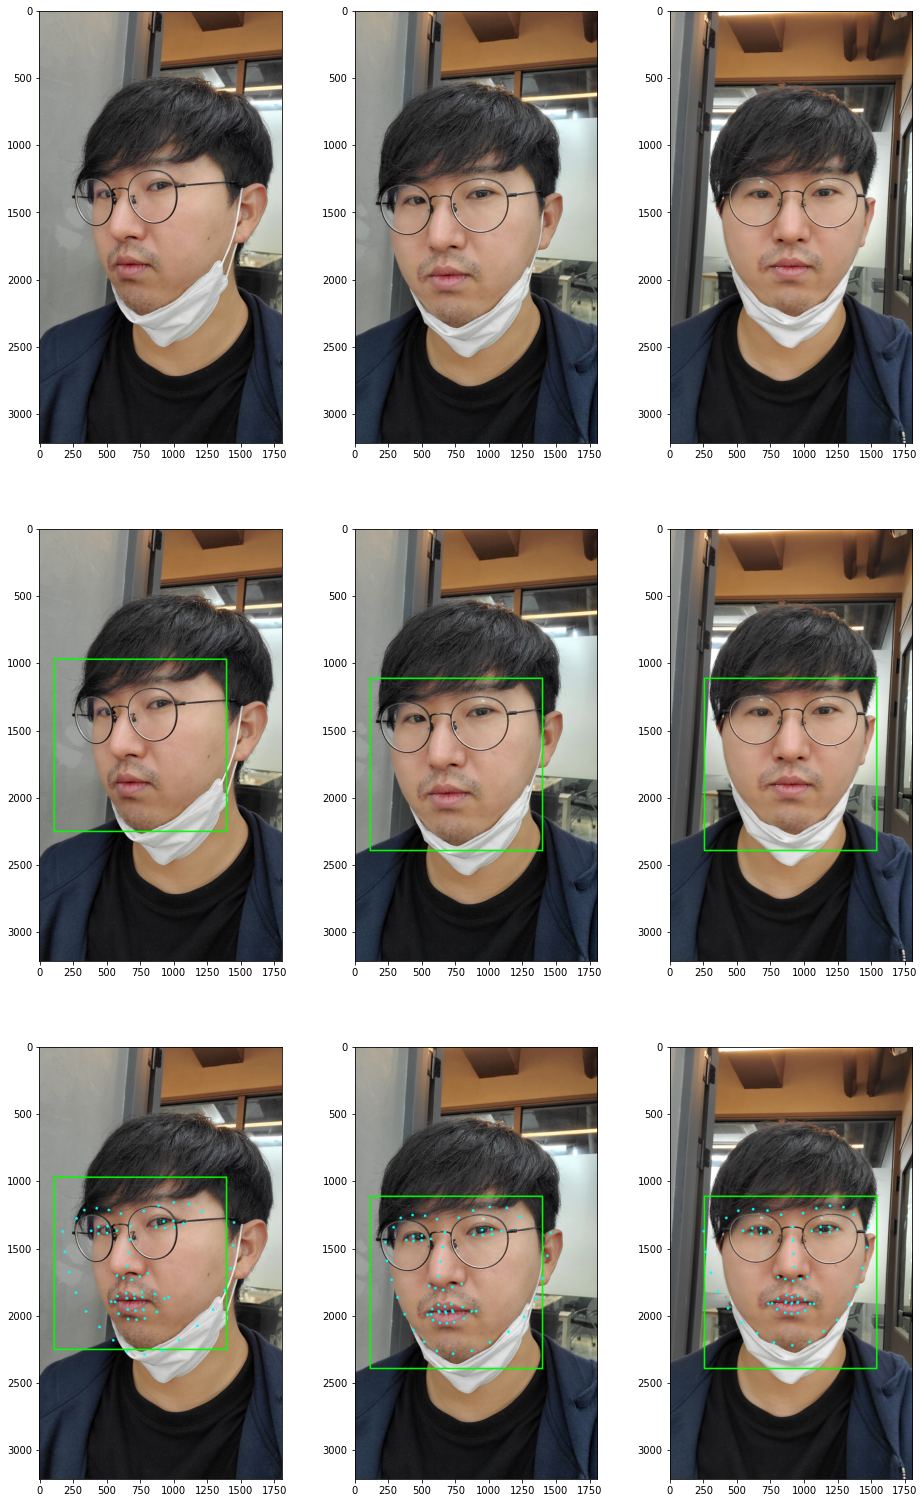

In [9]:
fig = plt.figure(figsize=(16,27))
for idx, i in enumerate(img_rgb_list + img_show_rect_list + img_show_p_list, 1):
  fig.add_subplot(330 + idx).imshow(i)
plt.show()

위에서 부터 각각
- 원본이미지
- 사각형으로 얼굴경계가 표시된 이미지
- 얼굴경계 + 이목구비가 점으로 표시된 이미지

순으로 표시함<br>
<br>
위의 사진의로 아래의 정보를 얻을 수 있다.
- 정면 얼굴 인식에는 이상이 없음을 확인
- 30°각도에서 얼굴을 찍었을 시에는 실재와 이목구비가 많이 다름
- 45°각도에서 얼굴을 찍었을 시에는 30°각도보다 더 인식률이 높음
- 30°,45°각도에서 눈의 이목구비가 안경 코받침으로 인식함을 확인
- 이에 따라 코, 입,하관 등의 이목구비가 재대로 인식을 못함

### 분석

`dlib.shape_predictor` class로  구할 수 있는 값은 라이브러리에서 이미 계산한 x,y좌표밖에 없다.<br> 
즉, 각 좌표의 정확도, 유사도가 높은 다른 좌표가 전혀 존재하지 않는다.<br>
그러므로 해당 라이브러리는
- 해당 좌표가 올바르게 찍혔는가?
- 좌표가 틀렸다고 가정할 경우 차선으로 사용할 수 있는 좌표가 있는가?

에 대한 대응이 불가능하다.<br>
아래의 링크는 클래스에 관한 문서이다.<br>
라이브러리 설명자료<br>
- [dlib.shape_predictor(모델을 로드한 객체의 클래스)](http://dlib.net/python/index.html#dlib_pybind11.shape_predictor)<br>
- [dlib.full_object_detection(이목구비의 x,y좌표를 표시하는 객체 클래스)](http://dlib.net/python/index.html#dlib_pybind11.full_object_detection) <br>
- [point(x,y 좌표)](http://dlib.net/python/index.html#dlib_pybind11.point)

또한 추가적으로 아래의 문제가 존제한다.
- 정면으로 찍힌 사진의 기준을 판별 가능한가?
- 이목구비의 점이 근접하지 않고 전혀 다른 위치를 가르키고 있는 경우 어떻게 할것인가?

위의 논리에 따라 아래의 해결방법을 생각하였다.
- 수식을 계산하여 위치를 보정한다.
- 성능이 좋은 다른 모델을 사용한다.
- HOG와 SVM방식의 얼굴검출을 DNN방식으로 바꾼다.

1안은 

